# Image Classification

### 1) Import and Setup

In [4]:
#Import the Needed Libraries
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2
import imghdr

In [5]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 2) Load the Data

In [6]:
#The pictures is loaded and size and batch size is arranged. Building data pipeline
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 689 files belonging to 2 classes.


In [7]:
# This data has some problematic images. First remove dodgy images
d_path = os.listdir('Data')
for sub_folder in d_path:
    s_path = os.listdir(os.path.join('Data', sub_folder))
    for image in s_path:
        i_path = os.path.join('Data', sub_folder, image)
        try:
            img = cv2.imread(i_path)
            tip = imghdr.what(i_path)
            if tip not in ['jpeg','jpg','bmp','png']:
                os.remove(i_path)
        except Exception as e:
                os.remove(i_path)

### 3) Preprocessing the Data

In [8]:
# Scale the images between 0-1 in the pipeline using map
data = data.map(lambda x,y: (x/255,y))

In [9]:
#This going to allow us to access to data from our data pipeline
data_iterator = data.as_numpy_iterator().next()

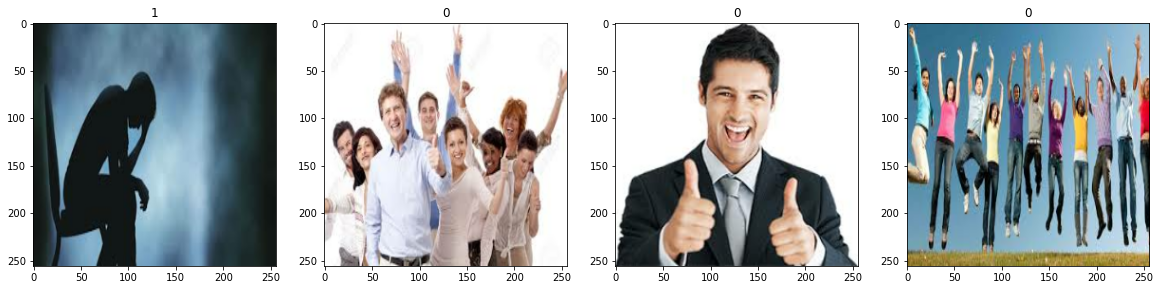

In [10]:
#Happy images has 0 title, sad images has 1 as a title.
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(data_iterator[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(data_iterator[1][idx])

In [11]:
#The Data will be separated into train, validation and test sets. We have 22 batch
train = data.take(int(len(data)*.7))
val = data.skip(int(len(data)*.7)).take(int(len(data)*.2))
test = data.skip(int(len(data)*.7)+int(len(data)*.2)).take(int(len(data)*.2)+1)

### 4) Model Building 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [13]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

### 5) Training the Data

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [16]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 [==============================] - 16s 526ms/step - loss: 0.8592 - accuracy: 0.5437 - val_loss: 0.6977 - val_accuracy: 0.5391
Epoch 2/20
15/15 [==============================] - 8s 496ms/step - loss: 0.6614 - accuracy: 0.6625 - val_loss: 0.6441 - val_accuracy: 0.5625
Epoch 3/20
15/15 [==============================] - 8s 471ms/step - loss: 0.5759 - accuracy: 0.7021 - val_loss: 0.5270 - val_accuracy: 0.6953
Epoch 4/20
15/15 [==============================] - 8s 479ms/step - loss: 0.4746 - accuracy: 0.7667 - val_loss: 0.4691 - val_accuracy: 0.7969
Epoch 5/20
15/15 [==============================] - 8s 473ms/step - loss: 0.3943 - accuracy: 0.8229 - val_loss: 0.4115 - val_accuracy: 0.7891
Epoch 6/20
15/15 [==============================] - 8s 471ms/step - loss: 0.3567 - accuracy: 0.8562 - val_loss: 0.2876 - val_accuracy: 0.8672
Epoch 7/20
15/15 [==============================] - 7s 468ms/step - loss: 0.2262 - accuracy: 0.9104 - val_loss: 0.1840 - val_accuracy: 0.9531
Epoch

### 6) Performance of the Model

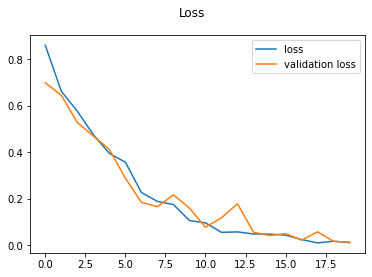

In [25]:
#The performance of the Model is examined
fig = plt.figure()
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend(loc = 'upper right')
fig.suptitle("Loss")
plt.show()

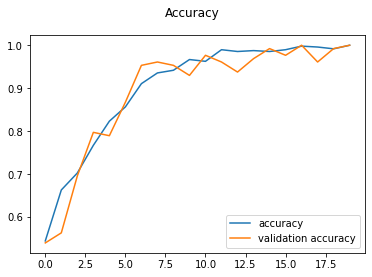

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend(loc = 'lower right')
fig.suptitle("Accuracy")
plt.show()

In [27]:
#Evaluation of the Model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

precision = Precision()
recall = Recall()
binaryAccuracy = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator():
    X,y = batch
    pred = model.predict(X)
    precision.update_state(y, pred)
    recall.update_state(y, pred)
    binaryAccuracy.update_state(y, pred)
print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Binary Accuracy: {binaryAccuracy.result().numpy()}')

1/1 [==============================] - 0s 36ms/step
Precision: 1.0
Recall: 1.0
Binary Accuracy: 1.0


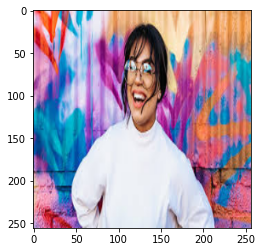

In [45]:
#Testing the model with image it doesn't seen before
img = cv2.imread('happy_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resized_img = tf.image.resize(img, (256, 256))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [46]:
new_test = model.predict(np.expand_dims(resized_img/255, 0))
if new_test > 0.5:
    print(f'The person is Sad')
else:
    print(f'The person is Happy')

1/1 [==============================] - 0s 25ms/step
The person is Happy


### 7) Save the Model

In [47]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'happysad_model.h5'))